This is the same data as zillow_main, but I will be taking extra features into account here to see if there is a significant difference.

In [1]:
import pandas as pd
import numpy as np
from env import get_db_url
import evaluate, split_scale
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.formula.api import ols
from math import sqrt

In [2]:
url = get_db_url('zillow')
query = ('''
SELECT *
FROM properties_2017
JOIN predictions_2017 USING (parcelid)
WHERE propertylandusetypeid = 261
    AND (transactiondate >= '2017-05-01' AND 
         transactiondate <= '2017-06-31')
''')
df_orig = pd.read_sql(query, url)

In [3]:
counties = pd.read_table('FIPS.txt', header=1)
counties.columns = ['FIPS', 'county', 'state']

In [4]:
df = df_orig.copy()

In [5]:
df = pd.merge(df, counties, left_on='fips', 
                 right_on='FIPS', how='left')
df.drop(columns='fips', inplace=True)
df.head()

,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id,logerror,transactiondate,FIPS,county,state
0,11289917,2061546,1.0,NaN,NaN,2.0,3.0,None,6.0,2.0,...,2319.90,Y,15.0,6.037901e+13,1248,-0.362001,2017-06-23,6037,Los Angeles,CA
1,11705026,1834372,NaN,NaN,NaN,1.0,2.0,None,6.0,1.0,...,543.69,None,NaN,6.037232e+13,1772,-0.146056,2017-06-30,6037,Los Angeles,CA
2,14269464,1923117,NaN,NaN,NaN,3.0,4.0,None,NaN,3.0,...,9819.72,None,NaN,6.059064e+13,2028,0.021085,2017-06-01,6059,Orange,CA
3,11389003,2121349,NaN,NaN,NaN,2.0,3.0,None,6.0,2.0,...,7673.19,None,NaN,6.037703e+13,3273,-0.325393,2017-06-01,6037,Los Angeles,CA
4,11967869,2093710,NaN,NaN,NaN,1.0,2.0,None,5.0,1.0,...,3267.47,None,NaN,6.037185e+13,3429,-0.005566,2017-06-29,6037,Los Angeles,CA


In [6]:
df.dropna(thresh=2000, axis=1, inplace=True)

In [7]:
df.drop(columns=['garagecarcnt','airconditioningtypeid',
                 'pooltypeid7', 'structuretaxvaluedollarcnt',
                 'buildingqualitytypeid','heatingorsystemtypeid',
                'propertyzoningdesc',#'regionidneighborhood',
                'threequarterbathnbr','unitcnt','id','logerror',
                'parcelid','assessmentyear','latitude','longitude',
                'finishedsquarefeet12','rawcensustractandblock',
                'transactiondate','fullbathcnt','regionidcity',
                'regionidcounty','regionidzip','calculatedbathnbr',
                'propertylandusetypeid','censustractandblock',
                'propertycountylandusecode',
                'landtaxvaluedollarcnt', 'taxamount'],inplace=True)

In [8]:
df.shape

(15036, 15)

In [9]:
df.isnull().sum()

bathroomcnt                         0
bedroomcnt                          0
calculatedfinishedsquarefeet       24
fireplacecnt                    12914
garagetotalsqft                  9771
lotsizesquarefeet                 104
poolcnt                         11746
regionidneighborhood             9533
roomcnt                             0
yearbuilt                          41
numberofstories                 10842
taxvaluedollarcnt                   0
FIPS                                0
county                              0
state                               0
dtype: int64

In [10]:
df.county.value_counts()

Los Angeles    9630
Orange         4109
Ventura        1297
Name: county, dtype: int64

In [11]:
df.head(1)

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fireplacecnt,garagetotalsqft,lotsizesquarefeet,poolcnt,regionidneighborhood,roomcnt,yearbuilt,numberofstories,taxvaluedollarcnt,FIPS,county,state
0,2.0,3.0,1458.0,NaN,NaN,8284.0,1.0,NaN,0.0,1970.0,NaN,136104.0,6037,Los Angeles,CA


In [12]:
bathroom_std = df.bathroomcnt.std()
bedroom_std = df.bedroomcnt.std()
square_feet_std = df.calculatedfinishedsquarefeet.std()
house_value_std = df.taxvaluedollarcnt.std()

df.bedroomcnt = df.bedroomcnt[(df.bedroomcnt <= bedroom_std * 5) &
                       (df.bedroomcnt != 0)]
df.bathroomcnt = df.bathroomcnt[(df.bathroomcnt <= bathroom_std* 5) 
                                & (df.bathroomcnt != 0) ]
df.calculatedfinishedsquarefeet = df.calculatedfinishedsquarefeet[
    (df.calculatedfinishedsquarefeet <= square_feet_std * 5) &
    (df.calculatedfinishedsquarefeet >= square_feet_std * .2)]
df.taxvaluedollarcnt = df.taxvaluedollarcnt[
    (df.taxvaluedollarcnt <= house_value_std * 5) & 
    (df.taxvaluedollarcnt >= house_value_std * .2)]

In [13]:
garage_std = df.garagetotalsqft.std()
lot_std = df.lotsizesquarefeet.std()

df.garagetotalsqft = df.garagetotalsqft[
    (df.garagetotalsqft <= garage_std * 5) & 
    (df.garagetotalsqft >= garage_std * .2)]
df.lotsizesquarefeet = df.lotsizesquarefeet[
    (df.lotsizesquarefeet <= lot_std * 5) & 
    (df.lotsizesquarefeet >= lot_std * .2)]

In [14]:
df.fireplacecnt = df.fireplacecnt.fillna(value=0)

In [15]:
df.poolcnt = df.poolcnt.fillna(value=0)

In [16]:
df.numberofstories = df.numberofstories.fillna(value=1)

In [17]:
df.garagetotalsqft = df.garagetotalsqft.fillna(value=0)

In [18]:
df.isnull().sum()

bathroomcnt                      270
bedroomcnt                      1418
calculatedfinishedsquarefeet     246
fireplacecnt                       0
garagetotalsqft                    0
lotsizesquarefeet               5321
poolcnt                            0
regionidneighborhood            9533
roomcnt                            0
yearbuilt                         41
numberofstories                    0
taxvaluedollarcnt               2911
FIPS                               0
county                             0
state                              0
dtype: int64

In [19]:
df.shape

(15036, 15)

In [20]:
df.dropna(inplace=True)
df.shape

(2536, 15)

In [21]:
dfLA = df[df.county == 'Los Angeles']
dfO = df[df.county == 'Orange']
dfV = df[df.county == 'Ventura']

In [22]:
dfLA = dfLA.drop(columns=['county','state'])
dfO = dfO.drop(columns=['county','state'])

In [23]:
trainLA, testLA = split_scale.split_my_data(dfLA, .8)
trainO, testO = split_scale.split_my_data(dfO, .8)

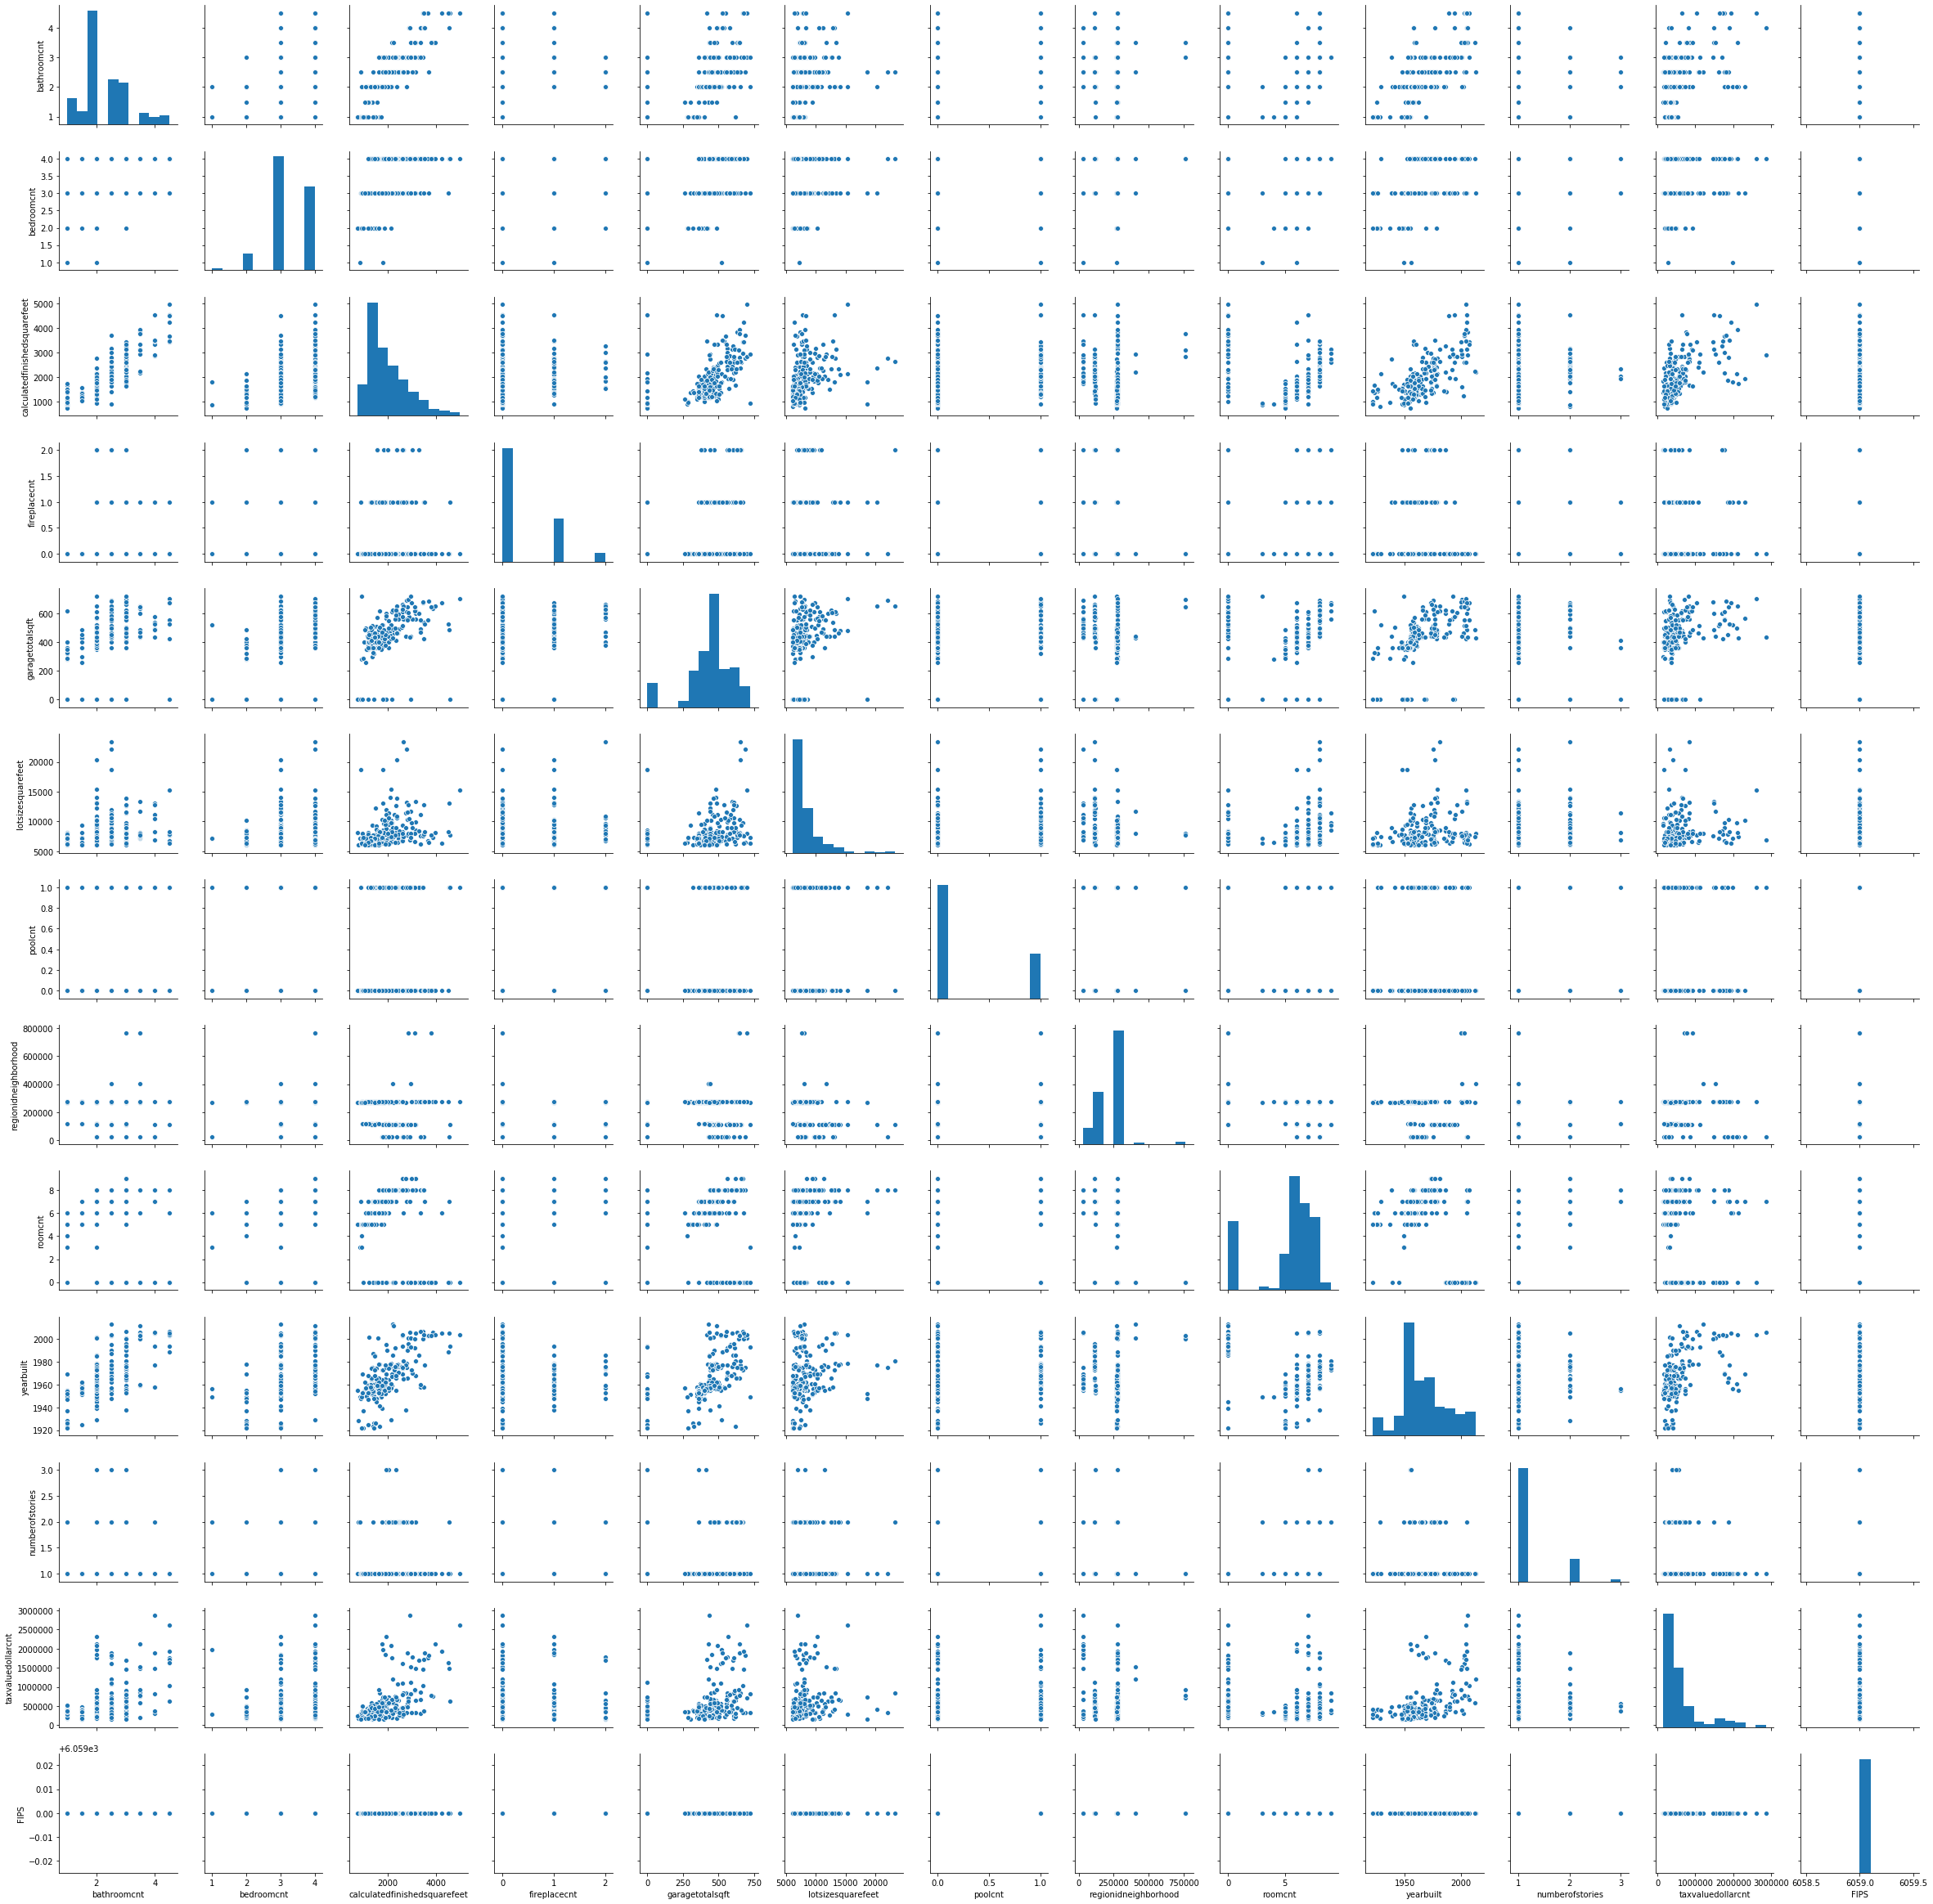

In [24]:
sns.pairplot(trainO)

In [25]:
trainO.taxvaluedollarcnt.max()

2862804.0

In [26]:
trainO.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fireplacecnt,garagetotalsqft,lotsizesquarefeet,poolcnt,regionidneighborhood,roomcnt,yearbuilt,numberofstories,taxvaluedollarcnt,FIPS
8955,2.0,3.0,2043.0,0.0,460.0,7350.0,1.0,113455.0,6.0,1964.0,2.0,368075.0,6059
4938,2.0,4.0,1902.0,0.0,462.0,7848.0,1.0,275470.0,8.0,1965.0,1.0,560925.0,6059
3603,3.0,3.0,2351.0,0.0,410.0,8200.0,0.0,118872.0,7.0,1955.0,3.0,378679.0,6059
12751,3.0,3.0,2826.0,0.0,556.0,7752.0,0.0,113455.0,0.0,1990.0,1.0,564965.0,6059
5952,3.0,4.0,2042.0,0.0,399.0,9520.0,1.0,268585.0,7.0,1956.0,1.0,727006.0,6059


In [27]:
X_trainO = trainO.drop(columns='taxvaluedollarcnt')
y_trainO = trainO.taxvaluedollarcnt

In [56]:
selector = SelectKBest(f_regression, k=4)
selector.fit(X_trainO, y_trainO)
X2 = selector.transform(X_trainO)

support = selector.get_support()
kbest_list = X_trainO.columns[support].tolist()
kbest_list

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


['bathroomcnt', 'calculatedfinishedsquarefeet', 'garagetotalsqft', 'yearbuilt']

In [49]:
rfe = RFE(LinearRegression(), 4)
X_rfe = rfe.fit_transform(X_trainO, y_trainO)
mask = rfe.support_
rfe_list = X_trainO.columns[mask].tolist()
rfe_list

['bathroomcnt', 'fireplacecnt', 'poolcnt', 'numberofstories']

In [30]:
predictions = pd.DataFrame({'actual': trainO.taxvaluedollarcnt})
predictions.head()

,actual
8955,368075.0
4938,560925.0
3603,378679.0
12751,564965.0
5952,727006.0


In [31]:
predictions['base_average'] = trainO.taxvaluedollarcnt.mean()
predictions.base_average = predictions.base_average.astype(int)
predictions.head()

,actual,base_average
8955,368075.0,608524
4938,560925.0,608524
3603,378679.0,608524
12751,564965.0,608524
5952,727006.0,608524


In [32]:
simple_lm_all = LinearRegression()
simple_lm_all.fit(X_trainO, y_trainO)
predictions['simple_lm_all'] = simple_lm_all.predict(X_trainO)
predictions.simple_lm_all = predictions.simple_lm_all.astype(int)
predictions.head()

,actual,base_average,simple_lm_all
8955,368075.0,608524,597938
4938,560925.0,608524,602793
3603,378679.0,608524,302923
12751,564965.0,608524,1083287
5952,727006.0,608524,457725


In [57]:
XO = trainO[kbest_list]

simple_lm_k3 = LinearRegression()
simple_lm_k3.fit(XO, y_trainO)
predictions['simple_lm_k3'] = simple_lm_k3.predict(XO)
predictions.simple_lm_k3 = predictions.simple_lm_k3.astype(int)
predictions.head()

,actual,base_average,simple_lm_all,simple_lm_k3,rfe
8955,368075.000,608524,597938,638150,461400
4938,560925.000,608524,602793,590366,565029
3603,378679.000,608524,302923,602748,610818
12751,564965.000,608524,1083287,967780,818075
5952,727006.000,608524,457725,492946,875999


In [58]:
lm_rfe = LinearRegression()
rfe_use = RFE(lm_rfe, 4)
rfe_use.fit(X_trainO, y_trainO)
X_rfe = rfe_use.transform(X_trainO)
lm_rfe.fit(X_rfe, y_trainO)

predictions['rfe'] = lm_rfe.predict(X_rfe)
predictions.rfe = predictions.rfe.astype(int)
predictions.head()

,actual,base_average,simple_lm_all,simple_lm_k3,rfe
8955,368075.000,608524,597938,638150,461400
4938,560925.000,608524,602793,590366,565029
3603,378679.000,608524,302923,602748,610818
12751,564965.000,608524,1083287,967780,818075
5952,727006.000,608524,457725,492946,875999


In [59]:
pd.options.display.float_format = '{:.3f}'.format
predictions.apply(lambda c: sqrt(mse(predictions.actual, c)))

actual               0.000
base_average    512659.743
simple_lm_all   387811.731
simple_lm_k3    400581.561
rfe             445672.973
dtype: float64

In [60]:
X_testO = testO.drop(columns='taxvaluedollarcnt')
y_testO = testO.taxvaluedollarcnt

In [61]:
y_test_predictions = simple_lm_all.predict(X_testO)
rmse = sqrt(mse(y_testO, y_test_predictions))
rmse

276822.44999766204

In [62]:
X_test_k3 = testO[kbest_list]
y_test_predictions_k3 = simple_lm_k3.predict(X_test_k3)

k3_rmse = sqrt(mse(y_testO, y_test_predictions_k3))
k3_rmse

221374.5642194335

In [63]:
X_test_rfe = testO[rfe_list]
y_test_predictions_rfe = lm_rfe.predict(X_test_rfe)

rfe_rmse = sqrt(mse(y_testO, y_test_predictions_rfe))
rfe_rmse

243930.9751234221

In [64]:
model = ols('y_testO ~ X_testO', data=testO).fit()
r2, p = evaluate.model_significance(model)
r2, p

(0.6697580990591143, 1.0588651126323675e-06)

In [65]:
model = ols('y_testO ~ X_test_k3', data=testO).fit()
r2, p = evaluate.model_significance(model)
r2, p

(0.6324855129684499, 9.645981433793797e-10)

In [66]:
model = ols('y_testO ~ X_test_rfe', data=testO).fit()
r2, p = evaluate.model_significance(model)
r2, p

(0.5816799361285072, 1.8701180007495935e-08)

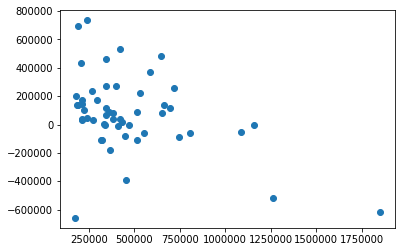

In [67]:
evaluate.plot_residuals(y_testO, y_test_predictions)

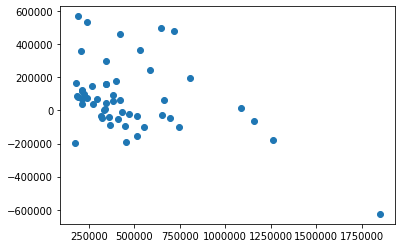

In [68]:
evaluate.plot_residuals(y_testO, y_test_predictions_k3)

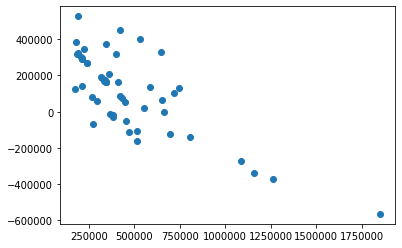

In [69]:
evaluate.plot_residuals(y_testO, y_test_predictions_rfe)

After having tried multiple combinations of kbest and RFE models, these were the two that seemed best. Looking at them, there is very little difference in using all these extra features, so that likely means there is still a piece of data that is missing or not being taken into account, or that this data needs a nonlinear model to be most accurate. If I had to guess, looking at the pairplot above, multiple factors were just not counted in many houses, so when I replaced NULLs with minimum numbers, that misrepresented the data.
I would bet that neighborhood data would be important as well, but it was not collected well enough to use.

In [70]:
df.regionidneighborhood

10      272933.000
14      273837.000
23      274582.000
24       41131.000
25       13017.000
           ...    
14995   274514.000
14997   113455.000
15017    27987.000
15024   268134.000
15025    41131.000
Name: regionidneighborhood, Length: 2536, dtype: float64